#### catatan: 
beberapa data taksonomi memang kosong dari NCBInya, misal data interaksi virus pycv malah terhubung ke genus capsicum bukan spesies capsicum. dan itu memang dari data GloBInya langsung

In [182]:
# # reset import package
# def reloadPackageOwn():
#     from importlib import reload  
#     import os # we use os.path.join, os.path.basename
#     import sys # we use sys.path
#     import glob # we use glob.glob
#     import importlib # we use importlib.import_module

#     import_folder = os.getcwd()
#     sys.path.append(import_folder) # this tells python to look in `import_folder` for imports
#     for src_file in glob.glob(os.path.join(import_folder, '*.py')):
#         name = os.path.basename(src_file)[:-3]
#         importlib.import_module(name)
#         reload(sys.modules[name])
#         importlib.import_module(name)
        
# reloadPackageOwn()

In [183]:
from tqdm import tqdm
from pyrdf2vec import RDF2VecTransformer
from pyrdf2vec.graphs import KG, Vertex
from pyrdf2vec.embedders import FastText,Word2Vec
from pyrdf2vec.walkers import RandomWalker
from pyvis.network import Network
from sklearn.manifold import TSNE
from umap import UMAP
from SPARQLWrapper import SPARQLWrapper
from jcopml.plot import plot_missing_value

import plotly.express as px
import pandas as pd
import numpy as np
import requests
import os
import networkx as nx
import matplotlib.pyplot as plt

from modul.vectorReferenced import get_taxon_vector,cek_ncbi_id_by_wiki_id_via_string
from modul.filterNodeEdge import removeNodeAndEdgeByFilter,removeEdgesNotInNodes
from modul.helper_umum import contains_string_entire_column,contains_string_entire_column_boolean
#from process import cek_bfs, nx_to_pyviz

#### Parameter

In [184]:
data=[
    ('begomovirus_contoh_hasil','Pepper yellow leaf curl virus','Aleyrodidae','Bemisia Tabaci'),
    ('1cucu','Cucumber mosaic virus','Aphididae','Myzus persicae'),
    ('2cri','Tomato chlorosis virus','Aleyrodidae','Bemisia Tabaci'),
    ('3wai','Maize chlorotic dwarf virus','Cicadellidae','Graminella nigrifrons'),
    ('4beg','Tomato yellow leaf curl China virus','Aleyrodidae','Bemisia Tabaci'),
    ('5pol','Cereal yellow dwarf virus','Aphididae','Schizaphis graminum'),
    ('6pea','Pea enation mosaic virus 1','Aphididae','Acyrthosiphon pisum'),
    ('7cucur','Cucurbit yellow stunting disorder virus','Aleyrodidae','Bemisia Tabaci'),
    ('8ten','Rice stripe tenuivirus','Delphacidae','Laodelphax striatellus'),
    ('9fiji','Southern rice black-streaked dwarf virus','Delphacidae','Sogatella furcifera'),
    ('10capchlo','Capsicum chlorosis orthotospovirus','Thripidae','Thrips Palmi'),
    ('11barley','Barley yellow dwarf virus GAV','Aphididae','Sitobion avenae'),
    ('12tospot','Tomato spotted wilt orthotospovirus','Thripidae','Frankliniella occidentalis'),
    ('13svyv','squash vein yellowing virus','Aleyrodidae','Bemisia Tabaci'),
    ('14sbmv','soybean mosaic virus','Aphididae','Aphis glycines'),
    ('15blv','bean leafroll virus','Aphididae','Acyrthosiphon pisum'),
    ('16rgdv','rice gall dwarf virus','Cicadellidae','Recilia dorsalis'), #sedikit
    ('17srbsdv','southern rice black-streaked dwarf virus','Delphacidae','Sogatella furcifera'),
    ('18tsrv','tomato severe rugose virus','Aleyrodidae','Bemisia tabaci'),
    ('19gbnv','groundnut bud necrosis virus','Thripidae','Thrips palmi'),
    ('20wbnv','Watermelon bud necrosis virus','Thripidae','Thrips palmi'),
    # error dibawah ini
    # ('+13Poty','Potyvirus','Aphididae','Myzus'),
    # ('+11tung','Tungrovirus','Nilaparvata','Nilaparvata'),
]

data_,nama_virus,acuan_,ujian_=data[0] # vektor acuan  #data virus
# link enpoint sparql ncbi_ontology
ncbi_ontology_url = 'http://localhost:3030/mydataset/query'

#### input data

In [185]:
#1
#baca data
df_node=pd.read_csv('dari_praproses/'+data_+'_node.csv',index_col=0) 
df_edge=pd.read_csv('dari_praproses/'+data_+'_edge.csv',index_col=0)

In [186]:
df_node[df_node['group']=='virus']
# df_node['group'].unique()

# df_node

,taxon_id,taxon_name,taxon_path,taxon_path_ids,taxon_path_rank,taxon_rank,superkingdom,kingdom,phylum,class,order,family,genus,species,group,color,virus_utama
44,NCBI:881944,Pepper yellow leaf curl virus,root | Viruses | Monodnaviria | Shotokuvirae |...,NCBI:1 | NCBI:10239 | NCBI:2731342 | NCBI:2732...,null | superkingdom | null | kingdom | phylum ...,NaN,NCBI:10239_Viruses,NCBI:2732092_Shotokuvirae,NCBI:2732416_Cressdnaviricota,NCBI:2732424_Repensiviricetes,NCBI:2732539_Geplafuvirales,NCBI:10811_Geminiviridae,NCBI:10814_Begomovirus,NCBI:881944_Pepper yellow leaf curl virus,virus,#671f92,True
45,NCBI:336987,Tobacco leaf curl Cuba virus,root | Viruses | Monodnaviria | Shotokuvirae |...,NCBI:1 | NCBI:10239 | NCBI:2731342 | NCBI:2732...,null | superkingdom | null | kingdom | phylum ...,NaN,NCBI:10239_Viruses,NCBI:2732092_Shotokuvirae,NCBI:2732416_Cressdnaviricota,NCBI:2732424_Repensiviricetes,NCBI:2732539_Geplafuvirales,NCBI:10811_Geminiviridae,NCBI:10814_Begomovirus,NCBI:336987_Tobacco leaf curl Cuba virus,virus,#671f92,True
46,NCBI:327280,Okra yellow mosaic Mexico virus,root | Viruses | Monodnaviria | Shotokuvirae |...,NCBI:1 | NCBI:10239 | NCBI:2731342 | NCBI:2732...,null | superkingdom | null | kingdom | phylum ...,NaN,NCBI:10239_Viruses,NCBI:2732092_Shotokuvirae,NCBI:2732416_Cressdnaviricota,NCBI:2732424_Repensiviricetes,NCBI:2732539_Geplafuvirales,NCBI:10811_Geminiviridae,NCBI:10814_Begomovirus,NCBI:327280_Okra yellow mosaic Mexico virus,virus,#671f92,True
47,NCBI:223262,East African cassava mosaic Cameroon virus,root | Viruses | Monodnaviria | Shotokuvirae |...,NCBI:1 | NCBI:10239 | NCBI:2731342 | NCBI:2732...,null | superkingdom | null | kingdom | phylum ...,NaN,NCBI:10239_Viruses,NCBI:2732092_Shotokuvirae,NCBI:2732416_Cressdnaviricota,NCBI:2732424_Repensiviricetes,NCBI:2732539_Geplafuvirales,NCBI:10811_Geminiviridae,NCBI:10814_Begomovirus,NCBI:223262_East African cassava mosaic Camero...,virus,#671f92,True
48,NCBI:223275,East African cassava mosaic Zanzibar virus,root | Viruses | Monodnaviria | Shotokuvirae |...,NCBI:1 | NCBI:10239 | NCBI:2731342 | NCBI:2732...,null | superkingdom | null | kingdom | phylum ...,NaN,NCBI:10239_Viruses,NCBI:2732092_Shotokuvirae,NCBI:2732416_Cressdnaviricota,NCBI:2732424_Repensiviricetes,NCBI:2732539_Geplafuvirales,NCBI:10811_Geminiviridae,NCBI:10814_Begomovirus,NCBI:223275_East African cassava mosaic Zanzib...,virus,#671f92,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2405,NCBI:2840014,Bemisia tabaci Quaranja-like virus 1,root | Viruses | Riboviria | Orthornavirae | N...,NCBI:1 | NCBI:10239 | NCBI:2559587 | NCBI:2732...,null | superkingdom | null | kingdom | phylum ...,NaN,NCBI:10239_Viruses,NCBI:2732396_Orthornavirae,NCBI:2497569_Negarnaviricota,NCBI:2497577_Insthoviricetes,NCBI:2499411_Articulavirales,NCBI:11308_Orthomyxoviridae,NCBI:1299308_Quaranjavirus,NCBI:2840014_Bemisia tabaci Quaranja-like virus 1,virus,#671f92,NaN
2408,NCBI:1986477,Bemisia-associated genomovirus AdDF,root | Viruses | Monodnaviria | Shotokuvirae |...,NCBI:1 | NCBI:10239 | NCBI:2731342 | NCBI:2732...,null | superkingdom | null | kingdom | phylum ...,NaN,NCBI:10239_Viruses,NCBI:2732092_Shotokuvirae,NCBI:2732416_Cressdnaviricota,NCBI:2732424_Repensiviricetes,NCBI:2732539_Geplafuvirales,NCBI:1910928_Genomoviridae,NCBI:1985365_Gemyduguivirus,NCBI:2844538_Gemyduguivirus bemta1,virus,#671f92,NaN
2409,NCBI:1986479,Bemisia-associated genomovirus NfO,root | Viruses | Monodnaviria | Shotokuvirae |...,NCBI:1 | NCBI:10239 | NCBI:2731342 | NCBI:2732...,null | superkingdom | null | kingdom | phylum ...,NaN,NCBI:10239_Viruses,NCBI:2732092_Shotokuvirae,NCBI:2732416_Cressdnaviricota,NCBI:2732424_Repensiviricetes,NCBI:2732539_Geplafuvirales,NCBI:1910928_Genomoviridae,NCBI:1941236_Gemykibivirus,NCBI:2844560_Gemykibivirus bemta1,virus,#671f92,NaN
2410,NCBI:1986478,Bemisia-associated genomovirus AdO,root | Viruses | Monodnaviria | Shotokuvirae |...,NCBI:1 | NCBI:10239 | NCBI:2731342 | NCBI:2732...,null | 

In [187]:
acuan_

'Aleyrodidae'

In [188]:
# pra-proses khusus proses
# hapus serangga yg cuma famili (mengikuti acuan). soalnya klo cuma tampil famili apa gunanya?
filter_genus_sampai_species_null=(
    (df_node.genus.isnull()) &
    (df_node.species.isnull()) &
    (df_node['class']=='NCBI:50557_Insecta')
)
df_node,df_edge = removeNodeAndEdgeByFilter(df_node[filter_genus_sampai_species_null], df_node,df_edge)

removeNodeAndEdgeByFilter
sebelum : 2667 5101
sesudah : 2641 4989


In [189]:
print(len(df_edge))
df_edge.drop_duplicates(inplace=True)
print(len(df_edge))

4989
4989


In [190]:
# pra-proses khusus proses
#isi data kosong. mengisi takson kosong, dengan takson sebelumnya, untuk tambalan
takson=[
    'superkingdom','kingdom','phylum','class','order','family','genus','species'
]

for x,i in enumerate(takson):
    if (i!='superkingdom'): #selain superkingdom update dengan data sebelumnya
        for idx, row in df_node[pd.isnull(df_node[i])].iterrows():
            df_node.loc[idx,[i]] = row[takson[x-1]]+'^'+i
    else: 
        for idx, row in df_node[pd.isnull(df_node[i])].iterrows():
            df_node.loc[idx,[i]] = row[takson[x+1]]+'^'+i

In [191]:
# pra-proses khusus proses
# eksperimen tambahan. bikin fakta tambahan, yaitu relasi virus utama dengan acuan 
# virus_utama=df_node[df_node.virus_utama==True].taxon_id.to_list()
# serangga_acuan=contains_string_entire_column(df_node,acuan_).taxon_id.to_list()
# print(len(df_edge))
# for i in virus_utama:
#     for j in serangga_acuan:
#         dict = {'source_taxon_id':i,'target_taxon_id':j,'interaction_type':'pathogenOf'}
#         df_edge = pd.concat([pd.DataFrame(dict,index=[0]), df_edge], ignore_index = True)
#         # df_edge.loc[len(df_edge.index),['source_taxon_id','target_taxon_id','interaction_type']] = [i,j,'pathogenOf']
# print(len(df_edge))

#satu saja
virus_utama=df_node[df_node.virus_utama==True].taxon_id.to_list()
serangga_acuan=contains_string_entire_column(df_node,acuan_).taxon_id.to_list()
print(len(df_edge))
for j in serangga_acuan:
    dict = {'source_taxon_id':virus_utama[0],'target_taxon_id':j,'interaction_type':'pathogenOf'}
    df_edge = pd.concat([pd.DataFrame(dict,index=[0]), df_edge], ignore_index = True)
    # df_edge.loc[len(df_edge.index),['source_taxon_id','target_taxon_id','interaction_type']] = [i,j,'pathogenOf']
print(len(df_edge))


4989
4994


In [192]:
# Ini harusnya di praproses. tapi belum fix baiknya hapus atau tidak
# hapus yang bukan virus utama, terakhir akurasi 0.85, kalau berkurang hapus saja ini
bukan_virus_utama=(df_node['group']=="virus") & (df_node.virus_utama!=True)
df_node,df_edge = removeNodeAndEdgeByFilter(df_node[bukan_virus_utama], df_node,df_edge)

removeNodeAndEdgeByFilter
sebelum : 2641 4994
sesudah : 1779 3435


In [193]:
if(len(df_node[df_node['group']=="serangga"])<=2):
    print("cuma dua serangga")

# Konversi graf

In [194]:
#3
#konversi graph 
gnx = nx.MultiDiGraph()
#node
for i,a in df_node.iterrows():
    #mulai disini akan digunakan taksonomi bahasa indonesia pada data.
    gnx.add_node(
        a['taxon_id'],
        label=a['taxon_name'],
        superkingdom=a['superkingdom'],
        kingdom=a['kingdom'],
        filum=a['phylum'],
        kelas=a['class'],
        ordo=a['order'],
        famili=a['family'],
        genus=a['genus'],
        spesies=a['species'],
        group=a['group'],
        color=a['color'],
    )
#edge
for i,a in df_edge.iterrows():
    gnx.add_edge(
        a['source_taxon_id'],
        a['target_taxon_id'],
        label=a['interaction_type'],
    )

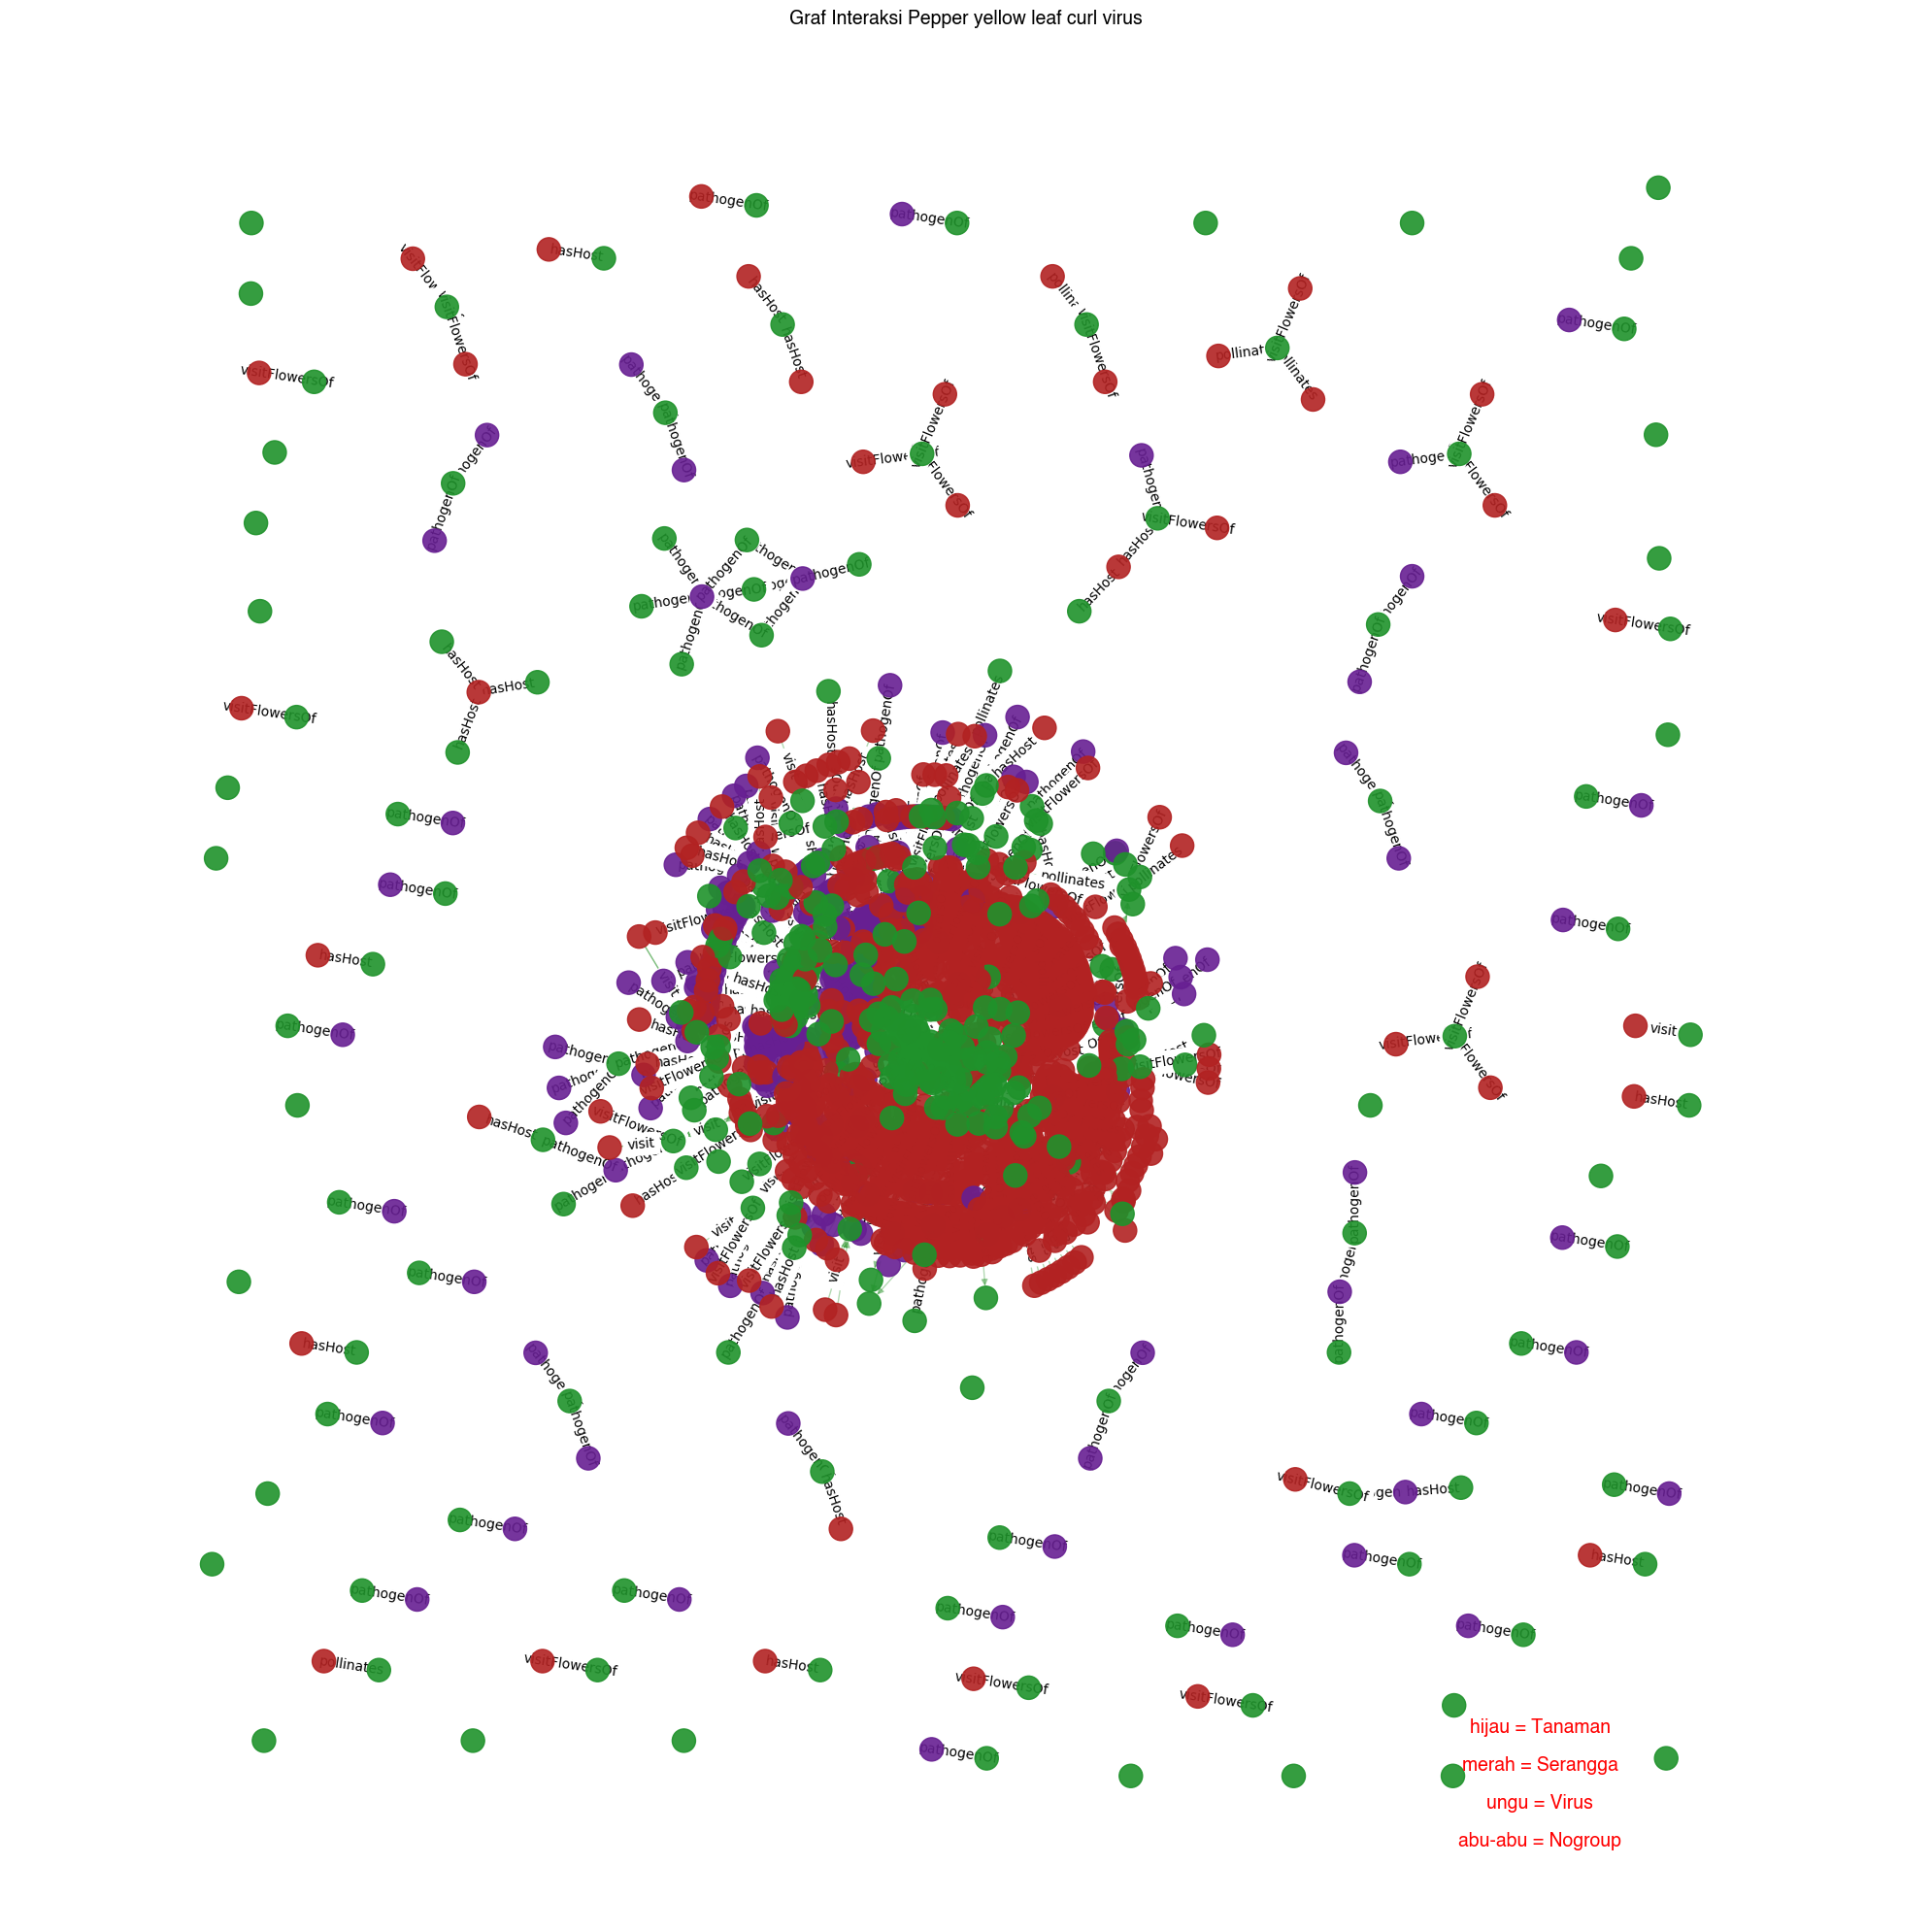

In [195]:
# cuma tampilan, visualisasi graf
G=gnx

fig, ax = plt.subplots(figsize=(20, 20))

# Generate layout for visualization
# pos = nx.kamada_kawai_layout(G)
# pos = nx.spring_layout(G)
pos = nx.nx_agraph.graphviz_layout(G, prog="neato", args="")

# Visualize graph components
nx.draw_networkx_edges(G, pos, alpha=0.3, edge_color='g')
nx.draw_networkx_nodes(G, pos, node_color=list(nx.get_node_attributes(G, "color").values()), alpha=0.9)

#node label
# for i in ['#b22222','#671f92','#1f922b','#EADDCA']: # filtering dengan bedakan warna node
#     label_options = {"ec": i, "fc": 'white', "alpha": 0.7}
#     nx.draw_networkx_labels(
#         nx.subgraph_view(G, filter_node=lambda n1: G.nodes(data=True)[n1].get("color", True) == i),
#         pos, 
#         font_size=10, 
#         bbox=label_options
#     )

#edge labels
edge_labels={x:i for i,x in zip(nx.get_edge_attributes(G, "label").values(),G.edges())}
nx.draw_networkx_edge_labels(G, pos=pos, edge_labels=edge_labels)


# Title/legend
font = {"fontname": "Helvetica", "color": "k", "fontweight": "bold", "fontsize": 14}
ax.set_title("Graf Interaksi "+nama_virus, font)
# Change font color for legend
font["color"] = "r"

ax.text(
    0.80,
    0.10,
    "hijau = Tanaman",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)
ax.text(
    0.80,
    0.08,
    "merah = Serangga",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

ax.text(
    0.80,
    0.06,
    "ungu = Virus",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

ax.text(
    0.80,
    0.04,
    "abu-abu = Nogroup",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

# Resize figure for label readibility
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()

In [285]:
import plotly.graph_objects as go
G=gnx
pos = nx.nx_agraph.graphviz_layout(G, prog="neato", args="")
edge_x = []
edge_y = []
for edge in G.edges():
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edge_x.append(x0)
    edge_x.append(x1)
    edge_x.append(None)
    edge_y.append(y0)
    edge_y.append(y1)
    edge_y.append(None)

edge_trace = go.Scatter(
    x=edge_x, y=edge_y,
    line= {"width":0.5, "color":'#888'},
    hoverinfo='none',
    mode='lines')

node_x = []
node_y = []
node_colors = []
node_text = []
for node,data in G.nodes(data=True):
    x, y = pos[node]
    node_x.append(x)
    node_y.append(y)
    node_colors.append(data['color'])
    node_text.append(data['label'])

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers',
    hoverinfo='text',
    marker={
        # 'showscale':True,
        # 'colorscale':'Reds',
        'reversescale':True,
        'color':[],
        'size':10,
        # 'colorbar':{
        #     # 'thickness':15,
        #     # 'title':'Node Connections',
        #     # 'xanchor':'left',
        #     # 'titleside':'right'
        # },
        'line_width':2   
    }
)
node_trace.marker.color = node_colors
node_trace.text = node_text

In [293]:
fig = go.Figure(
    data=[edge_trace, node_trace],
    layout=go.Layout(
        title='Network graph made with Python',
        titlefont_size=16,
        showlegend=False,
        hovermode='closest',
        margin={
            'b':20,'l':5,'r':5,'t':40
        },
        annotations=[{
            "text":"Insect-virus-plant",
            'showarrow':False,
            'xref':"paper", 
            'yref':"paper",
            'x':0.005, 
            'y':-0.002 
        }],
        xaxis={'showgrid':False, 'zeroline':False, 'showticklabels':False},
        yaxis={'showgrid':False, 'zeroline':False, 'showticklabels':False}
    )
)
fig.show()

In [261]:
# # # cuma tampilan, visualisasi pyviz
# from pyvis.network import Network
# nt = Network('500px', '900px',directed=True,notebook=True)
# # nt.show_buttons(filter_=['physics'])
# nt.toggle_physics(True)

# for i,data in df_node.iterrows():
#     nt.add_node(
#         data['taxon_id'],
#         label=data['taxon_name'],
#         superkingdom=data['superkingdom'],
#         kingdom=data['kingdom'],
#         filum=data['phylum'],
#         kelas=data['class'],
#         ordo=data['order'],
#         famili=data['family'],
#         genus=data['genus'],
#         spesies=data['species'],
#         # group=data['group'],
#         color=data['color'],
#         )
    
# for i,data in df_edge.iterrows():
#     nt.add_edge(
#         data['source_taxon_id'],
#         data['target_taxon_id'],
#         label=data['interaction_type'])

# # nt.show_buttons(filter_=['physics'])
# nt.show("tmp.fig02.html")

# Analisis Interaksi

In [138]:
from modul.custom_degree_centrality import degree_centrality_custom
import importlib, sys
importlib.reload(sys.modules['modul.custom_degree_centrality'])

#4 
# Degree Centrality Custom
virus_utama_ids=list(df_node[df_node['virus_utama']==True].taxon_id)
serangga_ids=list(df_node[df_node['group']=="serangga"].taxon_id)
results_dc = degree_centrality_custom(gnx,virus_utama_ids,serangga_ids)
allnodes = gnx.nodes

Papilio thoas NCBI:262664 | degree: 2 | langsung: 0 | melalui tanaman: 1
Epitrix subcrinita NCBI:1191541 | degree: 4 | langsung: 0 | melalui tanaman: 86
Neoleucinodes elegantalis NCBI:1511177 | degree: 3 | langsung: 0 | melalui tanaman: 85
Spodoptera littoralis NCBI:7109 | degree: 10 | langsung: 0 | melalui tanaman: 110
Autographa gamma NCBI:254363 | degree: 6 | langsung: 0 | melalui tanaman: 97
Spodoptera litura NCBI:69820 | degree: 10 | langsung: 0 | melalui tanaman: 127
Diabrotica speciosa NCBI:133126 | degree: 4 | langsung: 0 | melalui tanaman: 13
Helicoverpa armigera NCBI:29058 | degree: 12 | langsung: 0 | melalui tanaman: 111
Tetragonisca angustula NCBI:166442 | degree: 6 | langsung: 0 | melalui tanaman: 9
Frieseomelitta varia NCBI:561572 | degree: 5 | langsung: 0 | melalui tanaman: 13
Scaptotrigona hellwegeri NCBI:597186 | degree: 1 | langsung: 0 | melalui tanaman: 1
Thrips hawaiiensis NCBI:163894 | degree: 2 | langsung: 0 | melalui tanaman: 24
Bathrips melanicornis NCBI:1520562

In [139]:
urutan=sorted(results_dc.items(), key=lambda item: item[1], reverse=True)
urutan

[('NCBI:7038', 42.01574803149607),
 ('NCBI:88556', 0.26996625421822273),
 ('NCBI:166114', 0.07424071991001126),
 ('NCBI:267823', 0.058492688413948266),
 ('NCBI:7037', 0.0033745781777277844),
 ('NCBI:355109', 0.0),
 ('NCBI:262664', 0.0),
 ('NCBI:355026', 0.0),
 ('NCBI:340608', 0.0),
 ('NCBI:1191541', 0.0),
 ('NCBI:7139', 0.0),
 ('NCBI:1511177', 0.0),
 ('NCBI:7109', 0.0),
 ('NCBI:254363', 0.0),
 ('NCBI:69820', 0.0),
 ('NCBI:133126', 0.0),
 ('NCBI:29058', 0.0),
 ('NCBI:540886', 0.0),
 ('NCBI:1839606', 0.0),
 ('NCBI:355029', 0.0),
 ('NCBI:166442', 0.0),
 ('NCBI:57566', 0.0),
 ('NCBI:76712', 0.0),
 ('NCBI:561572', 0.0),
 ('NCBI:597186', 0.0),
 ('NCBI:115274', 0.0),
 ('NCBI:1137656', 0.0),
 ('NCBI:163894', 0.0),
 ('NCBI:1520562', 0.0),
 ('NCBI:1350418', 0.0),
 ('NCBI:407288', 0.0),
 ('NCBI:122869', 0.0),
 ('NCBI:224263', 0.0),
 ('NCBI:153012', 0.0),
 ('NCBI:163899', 0.0),
 ('NCBI:163893', 0.0),
 ('NCBI:133901', 0.0),
 ('NCBI:202456', 0.0),
 ('NCBI:30195', 0.0),
 ('NCBI:127405', 0.0),
 ('NCBI

In [140]:
#visualisasi data
# mengecek BFS Degree tertinggi
for to_search  in [urutan[0][0]]:#["NCBI:7038"]:#"NCBI:33377","NCBI:7036",
    for edge in nx.bfs_edges(gnx.to_undirected(), source=to_search, depth_limit=1):
            s_id, o_id = edge

            s_label = gnx.nodes[s_id]['label'] +' '+s_id
            o_label = gnx.nodes[o_id]['label'] +' '+o_id
            o_grup = gnx.nodes[o_id]['group']

            # skip subjek to_search
            if (o_grup == 'virus'):
                print(s_label,'-->', o_label)
    print('===============')

Bemisia tabaci NCBI:7038 --> Pepper yellow leaf curl virus NCBI:881944
Bemisia tabaci NCBI:7038 --> Chenopodium leaf curl virus [VEM] NCBI:1032479
Bemisia tabaci NCBI:7038 --> Mungbean yellow mosaic India virus NCBI:223287
Bemisia tabaci NCBI:7038 --> Sida golden mosaic virus - whitefly VEM Citra Florida NCBI:1032477


# Analisis Taksonomi

In [141]:
#5
# Ambil data NCBI
# data acuan
data_acuan=get_taxon_vector(acuan_,ncbi_ontology_url)
print(data_acuan)
data_ujian=get_taxon_vector(ujian_,ncbi_ontology_url)
print(data_ujian)

[('famili', 'NCBI:7036_Aleyrodidae'), ('ordo', 'NCBI:7524_Hemiptera'), ('kelas', 'NCBI:50557_Insecta'), ('filum', 'NCBI:6656_Arthropoda'), ('kingdom', 'NCBI:33208_Metazoa'), ('superkingdom', 'NCBI:2759_Eukaryota')]
[('spesies', 'NCBI:7038_Bemisia tabaci'), ('genus', 'NCBI:7037_Bemisia'), ('famili', 'NCBI:7036_Aleyrodidae'), ('ordo', 'NCBI:7524_Hemiptera'), ('kelas', 'NCBI:50557_Insecta'), ('filum', 'NCBI:6656_Arthropoda'), ('kingdom', 'NCBI:33208_Metazoa'), ('superkingdom', 'NCBI:2759_Eukaryota')]


In [142]:
#6
#konversi node networkx ke RDF
URL = "http://pyRDF2Vec"
CUSTOM_KG = KG()

takson=[i[0] for i in data_acuan]
for i in ["superkingdom","kingdom","filum","kelas"]:
    takson.remove(i) 

# memasukan RDF serangga acuan
subj = Vertex(f"{URL}#SERANGGA_ACUAN")
for i,j in data_acuan:
    if(i not in ["superkingdom","kingdom","filum","kelas"]):
        j = j.replace(' ','-')
        obj = Vertex((URL+"#"+j))
        pred = Vertex((URL+"#"+i), predicate=True, vprev=subj, vnext=obj)
        #pred = Vertex((URL+"#taxon_path_ids"), predicate=True, vprev=subj, vnext=obj)
        CUSTOM_KG.add_walk(subj, pred, obj)

# proses konversi 
for index,data in gnx.nodes(data=True):
    if(data['group']=='serangga'): #jika serangga
        subj = Vertex(URL+"#"+index)
        for i in takson:
            #if(isinstance(data[i], str)): #jika dia string atau tidak nan/kosong.
            #if(i not in ["superkingdom","kingdom","filum","kelas"]):
                id_takson=data[i].replace(' ','-')#.split('_')[0]
                obj = Vertex((URL+"#"+id_takson))
                pred = Vertex((URL+"#"+i), predicate=True, vprev=subj, vnext=obj)
                #pred = Vertex((URL+"#taxon_path_ids"), predicate=True, vprev=subj, vnext=obj)
                CUSTOM_KG.add_walk(subj, pred, obj)
# CUSTOM_KG.literals=[
#         [f"{URL}#taxon_path_ids"],
#     ]
CUSTOM_KG.literals = [[URL+"#"+i] for i in takson]

In [143]:
#7
#embedding
# Ensure the determinism of this script by initializing a pseudo-random number.
RANDOM_STATE = 22
transformer = RDF2VecTransformer(
    # Use one worker threads for Word2Vec to ensure random determinism.
    # Must be used with PYTHONHASHSEED.
    Word2Vec(epochs=1000),
    # Extract a maximum of 10 walks of a maximum depth of 4 for each entity
    # using two processes and use a random state to ensure that the same walks
    # are generated for the entities.
    walkers=[RandomWalker(2, 5, n_jobs=2, with_reverse=False, random_state=RANDOM_STATE)],
    #verbose=1,
)
# transformer = RDF2VecTransformer(verbose=1)
# list entity yang akan diembedd. serangga acuan urutan terakhir
ent = [ URL+"#"+index for index,data in gnx.nodes(data=True) if(data['group']=='serangga') ] #jika serangga
ent.append(f"{URL}#SERANGGA_ACUAN")
# Fit the transformer to the knowledge graph and the entities.
embeddings, _ = transformer.fit_transform(
    CUSTOM_KG, #the KG
    ent, #entity
)

In [144]:
# visualisasi

# Reduce the dimensions of entity embeddings to represent them in a 2D plane.
X= UMAP().fit_transform(embeddings)
df_umap=pd.DataFrame(X,columns=['feature-vector-1','feature-vector-2'])


text=[]
labels=[]
for x in transformer._entities:
    if(x!="http://pyRDF2Vec#SERANGGA_ACUAN"):
        text.append(gnx.nodes[x.split("#")[-1]]['famili'].split('_')[-1])
        labels.append(gnx.nodes[x.split("#")[-1]]['label'])
    else:
        text.append("#TITIK_VEKTOR_ACUAN")
        labels.append("#TITIK_VEKTOR_ACUAN")
df_umap['text']=text
df_umap['labels']=labels

# # gnx.nodes[x.split("#")[-1]]['label']
# df_umap['text']=list(map(lambda x: x.split("#")[-1],transformer._entities))
fig = px.scatter(df_umap, x='feature-vector-1',y='feature-vector-2',text='text',hover_name='labels')
fig.update_traces(textposition='top center')
fig.update_layout(
    height=650,
    title_text='reduced word2vec visualization'
)
fig.show()

In [145]:
#8
#euclidean distance

# buat dataframe
data_to_count=pd.DataFrame(embeddings, columns=list(range(0,100)))

# buat kolom label
ent=[data['label'] for index,data in gnx.nodes(data=True) if(data['group']=='serangga')] #jika serangga
ent.append("#SERANGGA_ACUAN")
data_to_count['label']=ent

#buat kolom entity
data_to_count['entity']=[i.replace("http://pyRDF2Vec#","") for i in transformer._entities]

# buat kolom hasil dc
for idx,row in data_to_count.iterrows(): #jika serangga acuan maka DC di isi nilai 1
    data_to_count.loc[idx,['dc_result']] = results_dc[row['entity']] if(row['entity']!="SERANGGA_ACUAN") else 1

#ambil koordinat acuan
acuan=next(data_to_count[data_to_count['label']=='#SERANGGA_ACUAN'].iterrows())[1]
acuan=np.array(tuple(acuan[i] for i in range(0,100)))
acuan

#hitung ED
for idx, row in data_to_count.iterrows():
    temp = np.array(tuple(row[i] for i in range(0,100)))
    data_to_count.loc[idx,['ed_result']] = np.linalg.norm(temp - acuan)

#drop data acuan
data_to_count.drop(data_to_count[data_to_count.label=="#SERANGGA_ACUAN"].index,inplace=True)

In [146]:
#drop kolom embedding
data_to_count.drop(columns=list(range(0,100)), inplace=True)

In [147]:
def minmax(data):
    return (data - data.min())/ (data.max() - data.min())

def std_scale(data):
    return (data - data.mean()) / data.std()


# simple scaling ed_result
# data_to_count["ed_result_scaled"] = data_to_count["ed_result"] / data_to_count["ed_result"].max()
data_to_count['ed_result_scaled'] = minmax(data_to_count['ed_result'])


# scaling dc 
# # dengan std
# data_to_count['dc_result_scaled'] = data_to_count['dc_result'] - data_to_count['dc_result'].mode()[0]
# # data_to_count['dc_result_scaled'] = data_to_count['dc_result']
# # lagi dengan minmax
# data_to_count["dc_result_scaled"] = data_to_count["dc_result_scaled"] / data_to_count["dc_result_scaled"].max()

# Perform scaling using standard deviation
# data_to_count['dc_result_scaled'] = std_scale(data_to_count['dc_result'])
# data_to_count['dc_result_scaled'] = minmax(data_to_count['dc_result_scaled'])

data_to_count['dc_result_scaled'] = minmax(data_to_count['dc_result'])


In [148]:
data_to_count

,label,entity,dc_result,ed_result,ed_result_scaled,dc_result_scaled
0,Quadrus lugubris,NCBI:355109,0.0,3.074802,0.675724,0.0
1,Papilio thoas,NCBI:262664,0.0,3.401395,0.754695,0.0
2,Ouleus,NCBI:355026,0.0,3.124696,0.687788,0.0
3,Pinnaspis piperis,NCBI:340608,0.0,2.145894,0.451111,0.0
4,Epitrix subcrinita,NCBI:1191541,0.0,3.309730,0.732530,0.0
...,...,...,...,...,...,...
1078,Eretmocerus eremicus,NCBI:272444,0.0,3.574997,0.796673,0.0
1079,Encarsia nigricephala,NCBI:121805,0.0,3.538371,0.787816,0.0
1080,Encarsia quaintancei,NCBI:32399,0.0,3.558430,0.792667,0.0
1081,Encarsia inaron,NCBI:121801,0.0,3.549410,0.790486,0.0


In [149]:
#9
#hitung kombinasi
# for idx, row in data_to_count.iterrows():
#     _dc = row['dc_result_scaled']
#     _ed=( (row['ed_result_scaled']) if row['ed_result_scaled']!=0 else 1)
#     data_to_count.loc[idx,['result']] = _dc/_ed

data_to_count['result'] = (1+data_to_count['dc_result_scaled']) / (1+data_to_count['ed_result_scaled'])

# simple scaling result (final/kombinasi)
data_to_count['result'] = data_to_count['result'] / data_to_count['result'].max()

# Pengujian

In [150]:
# DC
data_to_count=data_to_count.sort_values('dc_result',ascending=False).reset_index(drop=True)
data_to_count[['label','entity','dc_result']]

,label,entity,dc_result
0,Bemisia tabaci,NCBI:7038,42.015748
1,Trialeurodes vaporariorum,NCBI:88556,0.269966
2,Bemisia afer,NCBI:166114,0.074241
3,Aleurodicus dispersus,NCBI:267823,0.058493
4,Bemisia emiliae,NCBI:7037,0.003375
...,...,...,...
1078,Thrinchostoma torridum,NCBI:479790,0.000000
1079,Braunsapis bouyssoui,NCBI:175315,0.000000
1080,Thrinchostoma,NCBI:232812,0.000000
1081,Lasioglossum apristum,NCBI:88502,0.000000


In [151]:

# Pengujian dc
for urutan in range(0,3):
    takson=[i[0] for i in data_ujian if i[0] not in ["superkingdom","kingdom","filum","kelas"]]
    id_hasil=data_to_count.iloc[urutan].entity
    cek_hasil= { k:v for k,v in reversed(allnodes[id_hasil].items()) if k in takson }
    cek_ujian= { k:v for k,v in data_ujian if k in takson }
    # print(acuan_,'->', data_)
    # print('ujian ',cek_ujian)
    print('hasil ',cek_hasil)
    cek=0
    for i in reversed(takson):
        cekk=cek_hasil[i]==cek_ujian[i]
        cek+=cekk
        # print(i, cekk)
    print(cek/len(takson))

hasil  {'spesies': 'NCBI:7038_Bemisia tabaci', 'genus': 'NCBI:7037_Bemisia', 'famili': 'NCBI:7036_Aleyrodidae', 'ordo': 'NCBI:7524_Hemiptera'}
1.0
hasil  {'spesies': 'NCBI:88556_Trialeurodes vaporariorum', 'genus': 'NCBI:88555_Trialeurodes', 'famili': 'NCBI:7036_Aleyrodidae', 'ordo': 'NCBI:7524_Hemiptera'}
0.5
hasil  {'spesies': 'NCBI:166114_Bemisia afer', 'genus': 'NCBI:7037_Bemisia', 'famili': 'NCBI:7036_Aleyrodidae', 'ordo': 'NCBI:7524_Hemiptera'}
0.75


In [152]:
# ED
data_to_count=data_to_count.sort_values('ed_result',ascending=True).reset_index(drop=True)
data_to_count[['label','entity','ed_result']]

,label,entity,ed_result
0,Bemisia emiliae,NCBI:7037,0.280284
1,Aleurodicus dispersus,NCBI:267823,0.290548
2,Bemisia afer,NCBI:166114,0.293250
3,Trialeurodes vaporariorum,NCBI:88556,0.301929
4,Bemisia tabaci,NCBI:7038,0.379275
...,...,...,...
1078,Abracris flavolineata,NCBI:58570,4.177746
1079,Leptophyes punctatissima,NCBI:473660,4.189352
1080,Peru,NCBI:1634180,4.193314
1081,Heteronemia,NCBI:629302,4.367996


In [153]:
# Pengujian ed
for urutan in range(0,3):
    takson=[i[0] for i in data_ujian if i[0] not in ["superkingdom","kingdom","filum","kelas"]]
    id_hasil=data_to_count.iloc[urutan].entity
    cek_hasil= { k:v for k,v in reversed(allnodes[id_hasil].items()) if k in takson }
    cek_ujian= { k:v for k,v in data_ujian if k in takson }
    # print(acuan_,'->', data_)
    # print('ujian ',cek_ujian)
    print('hasil ',cek_hasil)
    cek=0
    for i in reversed(takson):
        cekk=cek_hasil[i]==cek_ujian[i]
        cek+=cekk
        # print(i, cekk)
    print(cek/len(takson))

hasil  {'spesies': 'EOL:12031772_Bemisiaemiliae', 'genus': 'NCBI:7037_Bemisia', 'famili': 'NCBI:7036_Aleyrodidae', 'ordo': 'NCBI:7524_Hemiptera'}
0.75
hasil  {'spesies': 'NCBI:267823_Aleurodicus dispersus', 'genus': 'NCBI:30098_Aleurodicus', 'famili': 'NCBI:7036_Aleyrodidae', 'ordo': 'NCBI:7524_Hemiptera'}
0.5
hasil  {'spesies': 'NCBI:166114_Bemisia afer', 'genus': 'NCBI:7037_Bemisia', 'famili': 'NCBI:7036_Aleyrodidae', 'ordo': 'NCBI:7524_Hemiptera'}
0.75


In [154]:
# final score kombinasi
data_to_count=data_to_count.sort_values('result',ascending=False).reset_index(drop=True)
data_to_count[['label','dc_result','ed_result','result']]

,label,dc_result,ed_result,result
0,Bemisia tabaci,42.015748,0.379275,1.000000
1,Trialeurodes vaporariorum,0.269966,0.301929,0.512575
2,Bemisia emiliae,0.003375,0.280284,0.512009
3,Aleurodicus dispersus,0.058493,0.290548,0.511412
4,Bemisia afer,0.074241,0.293250,0.511270
...,...,...,...,...
1078,Abracris flavolineata,0.000000,4.177746,0.263572
1079,Leptophyes punctatissima,0.000000,4.189352,0.263192
1080,Peru,0.000000,4.193314,0.263063
1081,Heteronemia,0.000000,4.367996,0.257475


In [155]:
# Pengujian kombinasi
for urutan in range(0,3):
    takson=[i[0] for i in data_ujian if i[0] not in ["superkingdom","kingdom","filum","kelas"]]
    id_hasil=data_to_count.iloc[urutan].entity
    cek_hasil= { k:v for k,v in reversed(allnodes[id_hasil].items()) if k in takson }
    cek_ujian= { k:v for k,v in data_ujian if k in takson }
    # print(acuan_,'->', data_)
    # print('ujian ',cek_ujian)
    print('hasil ',cek_hasil)
    cek=0
    for i in reversed(takson):
        cekk=cek_hasil[i]==cek_ujian[i]
        cek+=cekk
        # print(i, cekk)
    print(cek/len(takson))

hasil  {'spesies': 'NCBI:7038_Bemisia tabaci', 'genus': 'NCBI:7037_Bemisia', 'famili': 'NCBI:7036_Aleyrodidae', 'ordo': 'NCBI:7524_Hemiptera'}
1.0
hasil  {'spesies': 'NCBI:88556_Trialeurodes vaporariorum', 'genus': 'NCBI:88555_Trialeurodes', 'famili': 'NCBI:7036_Aleyrodidae', 'ordo': 'NCBI:7524_Hemiptera'}
0.5
hasil  {'spesies': 'EOL:12031772_Bemisiaemiliae', 'genus': 'NCBI:7037_Bemisia', 'famili': 'NCBI:7036_Aleyrodidae', 'ordo': 'NCBI:7524_Hemiptera'}
0.75


In [156]:
# Pengujian kombinasi
# cek=1
# takson=[i[0] for i in data_ujian if i[0] not in ["superkingdom","kingdom","filum","kelas"]]
# urutan=0
# while cek/len(takson)>0:
#     id_hasil=data_to_count.iloc[urutan].entity
#     cek_hasil= { k:v for k,v in reversed(allnodes[id_hasil].items()) if k in takson }
#     cek_ujian= { k:v for k,v in data_ujian if k in takson }
#     # print(acuan_,'->', data_)
#     # print('ujian ',cek_ujian)
#     print('hasil ', urutan ,cek_hasil)
#     cek=0
#     for i in reversed(takson):
#         cekk=cek_hasil[i]==cek_ujian[i]
#         cek+=cekk
#         # print(i, cekk)
#     print(cek/len(takson))
#     urutan+=1

# Visualisasi Hasil Analisis

In [157]:
import plotly.graph_objects as go

to_itter=data_to_count.sort_values('dc_result',ascending=False).reset_index(drop=True)[:10]

label=[]
degree=[]
for index,data in to_itter.sort_values('dc_result',ascending=True).reset_index(drop=True).iterrows():
    label.append(data.label)
    degree.append(data.dc_result)

fig = go.Figure(data=go.Bar(
    x=degree,
    y=label,
    orientation='h'
))

fig.update_layout(
    title='Degree centrality',
    xaxis_title='Degree',
    yaxis_title='Insect'
)

fig.show()

In [158]:
to_itter=data_to_count.sort_values('ed_result',ascending=True).reset_index(drop=True)[:10]

label=[]
degree=[]
for index,data in to_itter.sort_values('ed_result',ascending=False).reset_index(drop=True).iterrows():
    label.append(data.label)
    degree.append(data.ed_result)

fig = go.Figure(data=go.Bar(
    x=degree,
    y=label,
    orientation='h'
))

fig.update_layout(
    title='Euclidean distance',
    xaxis_title='Distance',
    yaxis_title='Insect'
)

fig.show()

In [159]:
import plotly.graph_objects as go

to_itter=data_to_count.sort_values('result',ascending=False).reset_index(drop=True)[:10]

label=[]
degree=[]
for index,data in to_itter.sort_values('result',ascending=True).reset_index(drop=True).iterrows():
    label.append(data.label)
    degree.append(data.result)

fig = go.Figure(data=go.Bar(
    x=degree,
    y=label,
    orientation='h'
))

fig.update_layout(
    title='final score',
    xaxis_title='Score',
    yaxis_title='Insect'
)

fig.show()

# Dibawah ini tidak termasuk

In [160]:
# #visualisasi data
# # mengecek BFS Degree tertinggi
# for edge in nx.bfs_edges(gnx.to_undirected(), source="NCBI:7038", depth_limit=1):
#         s_id, o_id = edge

#         s_label = gnx.nodes[s_id]['label'] +' '+s_id
#         o_label = gnx.nodes[o_id]['label'] +' '+o_id
#         o_grup = gnx.nodes[o_id]['group']

#         # skip subjek to_search

#         print(s_label,'-->', o_label)
# print('===============')

In [161]:
df_node[df_node['taxon_name'].str.contains('Thrips')]

,taxon_id,taxon_name,taxon_path,taxon_path_ids,taxon_path_rank,taxon_rank,superkingdom,kingdom,phylum,class,order,family,genus,species,group,color,virus_utama
380,NCBI:163894,Thrips hawaiiensis,Animalia | Arthropoda | Insecta | Thysanoptera...,GBIF:1 | NCBI:6656 | NCBI:50557 | NCBI:30262 |...,kingdom | phylum | class | order | family | ge...,NaN,NCBI:2759_Eukaryota,NCBI:33208_Metazoa,NCBI:6656_Arthropoda,NCBI:50557_Insecta,NCBI:30262_Thysanoptera,NCBI:45053_Thripidae,NCBI:45057_Thrips,NCBI:163894_Thrips hawaiiensis,serangga,#b22222,NaN
382,NCBI:1350418,Thrips parvispinus,Animalia | Arthropoda | Insecta | Thysanoptera...,GBIF:1 | NCBI:6656 | NCBI:50557 | NCBI:30262 |...,kingdom | phylum | class | order | family | ge...,NaN,NCBI:2759_Eukaryota,NCBI:33208_Metazoa,NCBI:6656_Arthropoda,NCBI:50557_Insecta,NCBI:30262_Thysanoptera,NCBI:45053_Thripidae,NCBI:45057_Thrips,NCBI:1350418_Thrips parvispinus,serangga,#b22222,NaN
503,NCBI:161013,Thrips palmi,Animalia | Arthropoda | Insecta | Thysanoptera...,GBIF:1 | NCBI:6656 | NCBI:50557 | NCBI:30262 |...,kingdom | phylum | class | order | family | ge...,NaN,NCBI:2759_Eukaryota,NCBI:33208_Metazoa,NCBI:6656_Arthropoda,NCBI:50557_Insecta,NCBI:30262_Thysanoptera,NCBI:45053_Thripidae,NCBI:45057_Thrips,NCBI:161013_Thrips palmi,serangga,#b22222,NaN
584,NCBI:161014,Thrips tabaci,Animalia | Arthropoda | Insecta | Thysanoptera...,GBIF:1 | NCBI:6656 | NCBI:50557 | NCBI:30262 |...,kingdom | phylum | class | order | family | ge...,NaN,NCBI:2759_Eukaryota,NCBI:33208_Metazoa,NCBI:6656_Arthropoda,NCBI:50557_Insecta,NCBI:30262_Thysanoptera,NCBI:45053_Thripidae,NCBI:45057_Thrips,NCBI:161014_Thrips tabaci,serangga,#b22222,NaN
585,NCBI:407017,Thrips nigropilosus,Animalia | Arthropoda | Insecta | Thysanoptera...,GBIF:1 | NCBI:6656 | NCBI:50557 | NCBI:30262 |...,kingdom | phylum | class | order | family | ge...,NaN,NCBI:2759_Eukaryota,NCBI:33208_Metazoa,NCBI:6656_Arthropoda,NCBI:50557_Insecta,NCBI:30262_Thysanoptera,NCBI:45053_Thripidae,NCBI:45057_Thrips,NCBI:407017_Thrips nigropilosus,serangga,#b22222,NaN
963,NCBI:45057,Thrips malloti,Animalia | Arthropoda | Insecta | Thysanoptera...,GBIF:1 | NCBI:6656 | NCBI:50557 | NCBI:30262 |...,kingdom | phylum | class | order | family | ge...,genus,NCBI:2759_Eukaryota,NCBI:33208_Metazoa,NCBI:6656_Arthropoda,NCBI:50557_Insecta,NCBI:30262_Thysanoptera,NCBI:45053_Thripidae,NCBI:45057_Thrips,GBIF:4799940_Thripsmalloti,serangga,#b22222,NaN


In [162]:
df_edge.interaction_type.unique()

array(['pathogenOf', 'hasHost', 'pollinates', 'visitFlowersOf', 'visit'],
      dtype=object)

In [163]:
ini=df_edge[df_edge['interaction_type'].isin(['visitFlowersOf'])]
ini

,source_taxon_id,target_taxon_id,interaction_type
513,NCBI:57566,NCBI:13196,visitFlowersOf
514,NCBI:76712,NCBI:13196,visitFlowersOf
516,NCBI:597186,NCBI:16739,visitFlowersOf
517,NCBI:115274,NCBI:130391,visitFlowersOf
558,NCBI:77572,NCBI:4071,visitFlowersOf
...,...,...,...
3365,NCBI:1053773,NCBI:2653735,visitFlowersOf
3366,NCBI:714786,NCBI:2653735,visitFlowersOf
3367,NCBI:596841,NCBI:2653735,visitFlowersOf
3368,NCBI:517685,NCBI:2653732,visitFlowersOf


In [164]:
df_node[df_node['taxon_id'].isin(
    ini.source_taxon_id.to_list()+
    ini.target_taxon_id.to_list()
)]

,taxon_id,taxon_name,taxon_path,taxon_path_ids,taxon_path_rank,taxon_rank,superkingdom,kingdom,phylum,class,order,family,genus,species,group,color,virus_utama
0,NCBI:3983,Manihot esculenta,Plantae | Tracheophyta | Magnoliopsida | Malpi...,GBIF:6 | NCBI:58023 | NCBI:3398 | NCBI:3646 | ...,kingdom | phylum | class | order | family | ge...,NaN,NCBI:2759_Eukaryota,NCBI:33090_Viridiplantae,NCBI:35493_Streptophyta,NCBI:3398_Magnoliopsida,NCBI:3646_Malpighiales,NCBI:3977_Euphorbiaceae,NCBI:3982_Manihot,NCBI:3983_Manihot esculenta,tanaman,#1f922b,NaN
2,NCBI:112408,Dimorphotheca sinuata,Plantae | Viridaeplantae | Streptophyta | Trac...,EOL_V2:281 | NCBI:33090 | EOL_V2:11823577 | NC...,kingdom | subkingdom | infrakingdom | phylum |...,NaN,NCBI:2759_Eukaryota,NCBI:33090_Viridiplantae,NCBI:35493_Streptophyta,NCBI:3398_Magnoliopsida,NCBI:4209_Asterales,NCBI:4210_Asteraceae,NCBI:13490_Dimorphotheca,NCBI:112408_Dimorphotheca sinuata,tanaman,#1f922b,NaN
3,NCBI:50207,Sonchus oleraceus,Plantae | Tracheophyta | Magnoliopsida | Aster...,EOL_V2:281 | NCBI:58023 | EOL:283 | NCBI:4209 ...,kingdom | phylum | class | order | family | ge...,NaN,NCBI:2759_Eukaryota,NCBI:33090_Viridiplantae,NCBI:35493_Streptophyta,NCBI:3398_Magnoliopsida,NCBI:4209_Asterales,NCBI:4210_Asteraceae,NCBI:50190_Sonchus,NCBI:50207_Sonchus oleraceus,tanaman,#1f922b,NaN
16,NCBI:37495,Euphorbia pulcherrima,root | cellular organisms | Eukaryota | Viridi...,NCBI:1 | NCBI:131567 | NCBI:2759 | NCBI:33090 ...,null | null | superkingdom | kingdom | phylum ...,NaN,NCBI:2759_Eukaryota,NCBI:33090_Viridiplantae,NCBI:35493_Streptophyta,NCBI:3398_Magnoliopsida,NCBI:3646_Malpighiales,NCBI:3977_Euphorbiaceae,NCBI:3990_Euphorbia,NCBI:37495_Euphorbia pulcherrima,tanaman,#1f922b,NaN
18,NCBI:189211,Crassocephalum crepidioides,root | cellular organisms | Eukaryota | Viridi...,NCBI:1 | NCBI:131567 | NCBI:2759 | NCBI:33090 ...,null | null | superkingdom | kingdom | phylum ...,NaN,NCBI:2759_Eukaryota,NCBI:33090_Viridiplantae,NCBI:35493_Streptophyta,NCBI:3398_Magnoliopsida,NCBI:4209_Asterales,NCBI:4210_Asteraceae,NCBI:189210_Crassocephalum,NCBI:189211_Crassocephalum crepidioides,tanaman,#1f922b,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1766,NCBI:55597,Ageratum corymbosum,Plantae | Tracheophyta | Magnoliopsida | Aster...,GBIF:6 | NCBI:58023 | NCBI:3398 | NCBI:4209 | ...,kingdom | phylum | class | order | family | ge...,genus,NCBI:2759_Eukaryota,NCBI:33090_Viridiplantae,NCBI:35493_Streptophyta,NCBI:3398_Magnoliopsida,NCBI:4209_Asterales,NCBI:4210_Asteraceae,NCBI:55597_Ageratum,GBIF:8026613_Ageratumcorymbosum,tanaman,#1f922b,NaN
1767,NCBI:2653735,Ageratum maritimum,Plantae | Tracheophyta | Magnoliophyta | Magno...,INAT_TAXON:47126 | NCBI:58023 | INAT_TAXON:471...,kingdom | subkingdom | phylum | class | order ...,NaN,NCBI:2759_Eukaryota,NCBI:33090_Viridiplantae,NCBI:35493_Streptophyta,NCBI:3398_Magnoliopsida,NCBI:4209_Asterales,NCBI:4210_Asteraceae,NCBI:55597_Ageratum,NCBI:2653735_Ageratum maritimum,tanaman,#1f922b,NaN
1768,NCBI:2653732,Ageratum corymbosum,Plantae | Tracheophyta | Angiospermae | Magnol...,INAT_TAXON:47126 | NCBI:58023 | INAT_TAXON:471...,kingdom | phylum | subphylum | class | order |...,NaN,NCBI:2759_Eukaryota,NCBI:33090_Viridiplantae,NCBI:35493_Streptophyta,NCBI:3398_Magnoliopsida,NCBI:4209_Asterales,NCBI:4210_Asteraceae,NCBI:55597_Ageratum,NCBI:2653732_Ageratum corymbosum,tanaman,#1f922b,NaN
1772,NCBI:3629,Tarasa capitata,Cellular organisms | Eukaryota | Viridiplantae...,EOL:6061725 | NCBI:2759 | NCBI:33090 | EOL_V2:...,null | null | kingdom | phylum | null | null |...,family,NCBI:2759_Eukaryota,NCBI:33090_Viridiplantae,NCBI:35493_Streptophyta,NCBI:3398_Magnoliopsida,NCBI:41938_Malvales,NCBI:3629_Malvaceae,EOL:5417947_Tarasa,EOL:5412066_Tarasacapitata,tanaman,#1f922b,NaN


In [165]:
contains_string_entire_column(df_edge,'NCBI:1341303')

,source_taxon_id,target_taxon_id,interaction_type


In [166]:
contains_string_entire_column(df_node,'NCBI:12315')

,taxon_id,taxon_name,taxon_path,taxon_path_ids,taxon_path_rank,taxon_rank,superkingdom,kingdom,phylum,class,order,family,genus,species,group,color,virus_utama
